Before running the code, please download the required package first like torch, numpy ...

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.nn.parameter import Parameter, UninitializedParameter
from torch.nn import init
import math
import torch.nn as nn
import torch.nn.functional as F
import os

d:\Anaconda\envs\GPU_Pytorchpy39\lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


The code below will automatically create a path './data' and download MNIST dataset

In [2]:
transform = transforms.Compose(
    [torchvision.transforms.ToTensor()])

batch_size = 64

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9')

Define the hardware tuning property <--- Hardware-aware training

In [3]:
def lorentzian_curve(x, A, x0, gamma):
    return -2 * A / (1 + ((x - x0) / gamma)**2) +A
def lorentzian_curve_derivative(x, A, x0, gamma):
    return 2 * A * (x - x0) / (gamma**2 * (1 + ((x - x0) / gamma)**2)**2)
def lorentzian_inv(y, A, x0, gamma):
    return gamma * ((A + y)/(A - y)) ** (1/2) + x0

Self defines the convolution layer and linear layer <--- Now we are optimizing the tuning currents/voltages, which differs directly optimizing the weights ! This is a very important step !

In [4]:
from torch.nn.modules.conv import _ConvNd
from torch.nn.common_types import _size_1_t, _size_2_t, _size_3_t
from torch.nn.modules.utils import _pair
from typing import Optional, List, Tuple, Union

In [5]:
class Conv2dLorentz(_ConvNd):

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: _size_2_t,
        stride: _size_2_t = 1,
        padding: Union[str, _size_2_t] = 0,
        dilation: _size_2_t = 1,
        groups: int = 1,
        bias: bool = True,
        padding_mode: str = 'zeros',  # TODO: refine this type
        device=None,
        dtype=None
    ) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        kernel_size_ = _pair(kernel_size)
        stride_ = _pair(stride)
        padding_ = padding if isinstance(padding, str) else _pair(padding)
        dilation_ = _pair(dilation)
        super().__init__(
            in_channels, out_channels, kernel_size_, stride_, padding_, dilation_,
            False, _pair(0), groups, bias, padding_mode, **factory_kwargs)

    def _conv_forward(self, input: torch.Tensor, weight: torch.Tensor, bias: Optional[torch.Tensor]):
        if self.padding_mode != 'zeros':
            return F.conv2d(F.pad(input, self._reversed_padding_repeated_twice, mode=self.padding_mode),
                            weight, bias, self.stride,
                            _pair(0), self.dilation, self.groups)
        return F.conv2d(input, weight, bias, self.stride,
                        self.padding, self.dilation, self.groups)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return self._conv_forward(input, lorentzian_curve(self.weight, 1, 0, 0.15), self.bias) ### <--- Here self.weight is voltage or current

In [6]:
class LinearLorentz(torch.nn.Module):
    __constants__ = ['in_features', 'out_features']
    in_features: int
    out_features: int
    weight: torch.Tensor

    def __init__(self, in_features: int, out_features: int, bias: bool = True,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.empty((out_features, in_features), **factory_kwargs))
        if bias:
            self.bias = Parameter(torch.empty(out_features, **factory_kwargs))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self) -> None:
        # Setting a=sqrt(5) in kaiming_uniform is the same as initializing with
        # uniform(-1/sqrt(in_features), 1/sqrt(in_features)). For details, see
        # https://github.com/pytorch/pytorch/issues/57109
        init.kaiming_uniform_(lorentzian_curve(self.weight, 1, 0, 0.15), a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(lorentzian_curve(self.weight, 1, 0, 0.15))
            bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
            init.uniform_(self.bias, -bound, bound)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return F.linear(input, lorentzian_curve(self.weight, 1, 0, 0.15), self.bias) ### <--- Here self.weight is voltage or current

    def extra_repr(self) -> str:
        return f'in_features={self.in_features}, out_features={self.out_features}, bias={self.bias is not None}'


In [7]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()

        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.norm1 = nn.BatchNorm2d(6)
        self.norm2 = nn.BatchNorm2d(16)
        self.norm3 = nn.BatchNorm1d(120)
        self.norm4 = nn.BatchNorm1d(84)

    def forward(self,x):

        x = F.max_pool2d(F.relu(self.norm1(self.conv1(x))), (2, 2))
        x = F.max_pool2d(F.relu(self.norm2(self.conv2(x))), (2, 2))

        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.norm3(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.norm4(x)
        x = F.relu(x)   
        x = self.fc3(x)

        return x

    def apply_constraints(self):
        self.conv1.cuda().weight.data = torch.clamp(self.conv1.cuda().weight.data, -0.999, 0.999)
        self.conv2.cuda().weight.data = torch.clamp(self.conv2.cuda().weight.data, -0.999, 0.999)
        self.fc1.cuda().weight.data = torch.clamp(self.fc1.cuda().weight.data, -0.999, 0.999)
        self.fc2.cuda().weight.data = torch.clamp(self.fc2.cuda().weight.data, -0.999, 0.999)
        self.fc3.cuda().weight.data = torch.clamp(self.fc3.cuda().weight.data, -0.999, 0.999)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)
net = LeNet5()
net.to(device)

cuda:0


LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (norm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm3): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm4): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [8]:
class LeNet5_Lorentz(nn.Module):
    def __init__(self):
        super(LeNet5_Lorentz, self).__init__()

        self.conv1 = Conv2dLorentz(1, 6, 5, padding=2)
        self.conv2 = Conv2dLorentz(6, 16, 5)
        self.fc1 = LinearLorentz(16*5*5, 120)
        self.fc2 = LinearLorentz(120, 84)
        self.fc3 = LinearLorentz(84, 10)
        self.norm1 = nn.BatchNorm2d(6)
        self.norm2 = nn.BatchNorm2d(16)
        self.norm3 = nn.BatchNorm1d(120)
        self.norm4 = nn.BatchNorm1d(84)

    def forward(self,x):

        x = F.max_pool2d(F.relu(self.norm1(self.conv1(x))), (2, 2))
        x = F.max_pool2d(F.relu(self.norm2(self.conv2(x))), (2, 2))
        x = x.view(x.size(0), -1) 
        x = self.fc1(x)
        x = self.norm3(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.norm4(x)
        x = F.relu(x)
        x = self.fc3(x)

        return x

    def apply_constraints(self):
        self.conv1.cuda().weight.data = torch.clamp(self.conv1.cuda().weight.data, min=0)
        self.conv2.cuda().weight.data = torch.clamp(self.conv2.cuda().weight.data, min=0)
        self.fc1.cuda().weight.data = torch.clamp(self.fc1.cuda().weight.data, min=0)
        self.fc2.cuda().weight.data = torch.clamp(self.fc2.cuda().weight.data, min=0)
        self.fc3.cuda().weight.data = torch.clamp(self.fc3.cuda().weight.data, min=0)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)
net_Lorentz = LeNet5_Lorentz()
net_Lorentz.to(device)

cuda:0


LeNet5_Lorentz(
  (conv1): Conv2dLorentz(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2dLorentz(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): LinearLorentz(in_features=400, out_features=120, bias=True)
  (fc2): LinearLorentz(in_features=120, out_features=84, bias=True)
  (fc3): LinearLorentz(in_features=84, out_features=10, bias=True)
  (norm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm3): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm4): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

### Standard Backpropagation Optimize weights

In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 400, gamma = 0.5)

In [17]:
net.to(device)
for epoch in range(20):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss0 = criterion(outputs, labels)
        loss = loss0
        loss.backward()
        optimizer.step()
        net.apply_constraints()
        running_loss += loss.item()
        if i % 600 == 599: 
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 600:.3f} Classification loss:{loss0.cpu().detach().numpy():.3f}')
            running_loss = 0.0
    scheduler.step()
    net.to(device)
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)          
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy 10000 test images: {100 * correct / total} %')
print('Finished Training')

[1,   600] loss: 0.140 Classification loss:0.047
Accuracy 10000 test images: 98.59 %
[2,   600] loss: 0.045 Classification loss:0.183
Accuracy 10000 test images: 98.45 %
[3,   600] loss: 0.035 Classification loss:0.031
Accuracy 10000 test images: 98.77 %
[4,   600] loss: 0.023 Classification loss:0.002
Accuracy 10000 test images: 98.69 %
[5,   600] loss: 0.020 Classification loss:0.036
Accuracy 10000 test images: 99.03 %
[6,   600] loss: 0.015 Classification loss:0.016
Accuracy 10000 test images: 99.08 %
[7,   600] loss: 0.011 Classification loss:0.008
Accuracy 10000 test images: 99.04 %
[8,   600] loss: 0.011 Classification loss:0.028
Accuracy 10000 test images: 99.16 %
[9,   600] loss: 0.010 Classification loss:0.025
Accuracy 10000 test images: 99.07 %
[10,   600] loss: 0.007 Classification loss:0.000
Accuracy 10000 test images: 99.11 %
[11,   600] loss: 0.007 Classification loss:0.007
Accuracy 10000 test images: 99.08 %
[12,   600] loss: 0.006 Classification loss:0.001
Accuracy 1000

-0.8070771
0.8852437


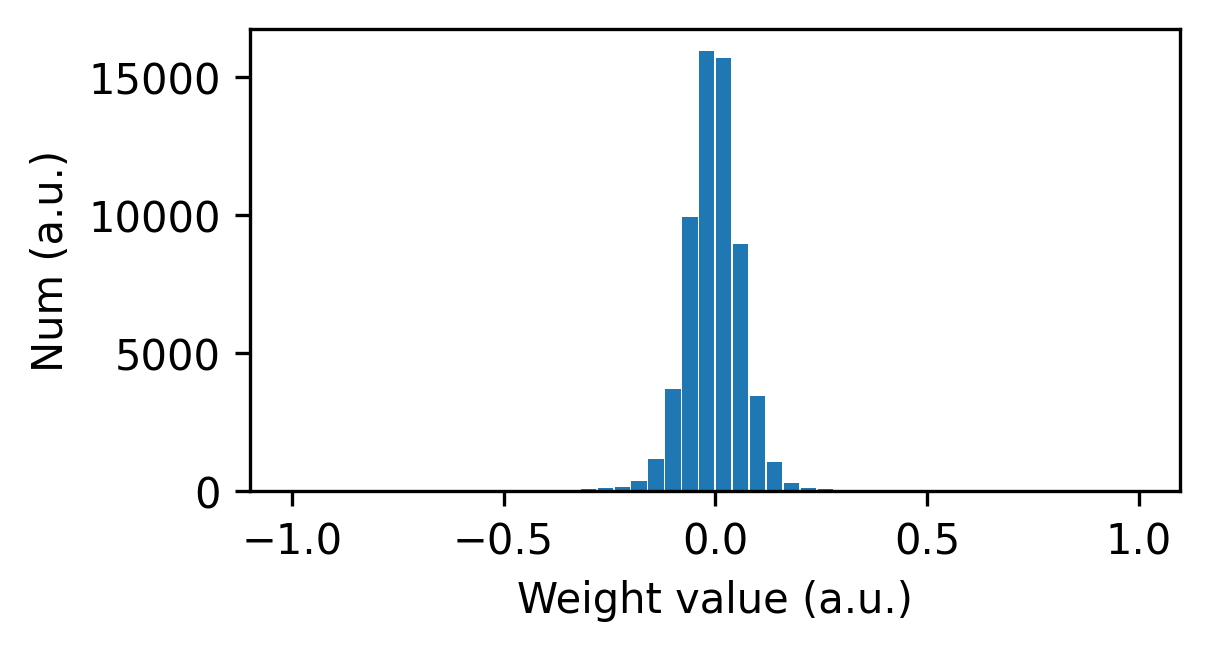

In [18]:
conv1_flat = net.conv1.cpu().weight.detach().numpy().flatten()
conv2_flat = net.conv2.cpu().weight.detach().numpy().flatten()
fc1_flat = net.fc1.cpu().weight.detach().numpy().flatten()
fc2_flat = net.fc2.cpu().weight.detach().numpy().flatten()
fc3_flat = net.fc3.cpu().weight.detach().numpy().flatten()
total_weight = np.hstack((conv1_flat, conv2_flat, fc1_flat, fc2_flat,fc3_flat))
print(np.min(total_weight))
print(np.max(total_weight))
plt.figure(figsize=(4,2),dpi=300)
plt.hist(total_weight,bins=50,range=(-1,1),rwidth=0.9)
plt.xlabel('Weight value (a.u.)')
plt.ylabel('Num (a.u.)')
plt.show()

In [19]:
file_name = '.\Training results/01-Standard BP.pth'
if os.path.exists(file_name):
    print('file exist, save failed')
else:
    torch.save(net.state_dict(), file_name)
    print('save done')

save done


### Standard Noise injection Optimize weights
Reference: 

[1] Mourgias-Alexandris, G., Moralis-Pegios, M., Tsakyridis, A., Simos, S., Dabos, G., Totovic, A., ... & Pleros, N. (2022). Noise-resilient and high-speed deep learning with coherent silicon photonics. Nature communications, 13(1), 5572. 

[2] Wu, C., Yang, X., Yu, H., Peng, R., Takeuchi, I., Chen, Y., & Li, M. (2022). Harnessing optoelectronic noises in a photonic generative network. Science advances, 8(3), eabm2956.

In [9]:
net = LeNet5()
net.to(device)

LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (norm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm3): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm4): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [11]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.05, momentum=0.5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 400, gamma = 0.5)

In [12]:
net.to(device)
for epoch in range(20):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        ### Noise injection
        conv1_data = net.conv1.weight.data
        conv2_data = net.conv2.weight.data
        fc1_data = net.fc1.weight.data
        fc2_data = net.fc2.weight.data        
        fc3_data = net.fc3.weight.data     
        net.conv1.weight.data = conv1_data + 0.3 * torch.randn(net.conv1.weight.data.shape).to(device)
        net.conv2.weight.data = conv2_data + 0.3 * torch.randn(net.conv2.weight.data.shape).to(device)
        net.fc1.weight.data = fc1_data + 0.3 * torch.randn(net.fc1.weight.data.shape).to(device)
        net.fc2.weight.data = fc2_data + 0.3 * torch.randn(net.fc2.weight.data.shape).to(device)
        net.fc3.weight.data = fc3_data + 0.3 * torch.randn(net.fc3.weight.data.shape).to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss0 = criterion(outputs, labels)
        loss = loss0
        net.conv1.weight.data = conv1_data 
        net.conv2.weight.data = conv2_data 
        net.fc1.weight.data = fc1_data 
        net.fc2.weight.data = fc2_data 
        net.fc3.weight.data = fc3_data 
        
        loss.backward()
        optimizer.step()
        net.apply_constraints()
        running_loss += loss.item()
        if i % 600 == 599:    
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 600:.3f} Classification loss:{loss0.cpu().detach().numpy():.3f}')
            running_loss = 0.0
    scheduler.step()
    net.to(device)
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)        
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy 10000 test images: {100 * correct / total} %')
print('Finished Training')

[1,   600] loss: 2.565 Classification loss:2.301
Accuracy 10000 test images: 19.15 %
[2,   600] loss: 2.299 Classification loss:2.260
Accuracy 10000 test images: 19.93 %
[3,   600] loss: 2.296 Classification loss:2.321
Accuracy 10000 test images: 19.14 %
[4,   600] loss: 2.286 Classification loss:2.303
Accuracy 10000 test images: 18.48 %
[5,   600] loss: 2.206 Classification loss:2.265
Accuracy 10000 test images: 22.37 %
[6,   600] loss: 2.050 Classification loss:1.875
Accuracy 10000 test images: 26.35 %
[7,   600] loss: 1.956 Classification loss:1.972
Accuracy 10000 test images: 28.85 %
[8,   600] loss: 1.858 Classification loss:1.773
Accuracy 10000 test images: 32.74 %
[9,   600] loss: 1.765 Classification loss:1.634
Accuracy 10000 test images: 34.59 %
[10,   600] loss: 1.677 Classification loss:1.613
Accuracy 10000 test images: 40.85 %
[11,   600] loss: 1.545 Classification loss:1.358
Accuracy 10000 test images: 54.74 %
[12,   600] loss: 1.224 Classification loss:0.857
Accuracy 1000

-0.999
0.999


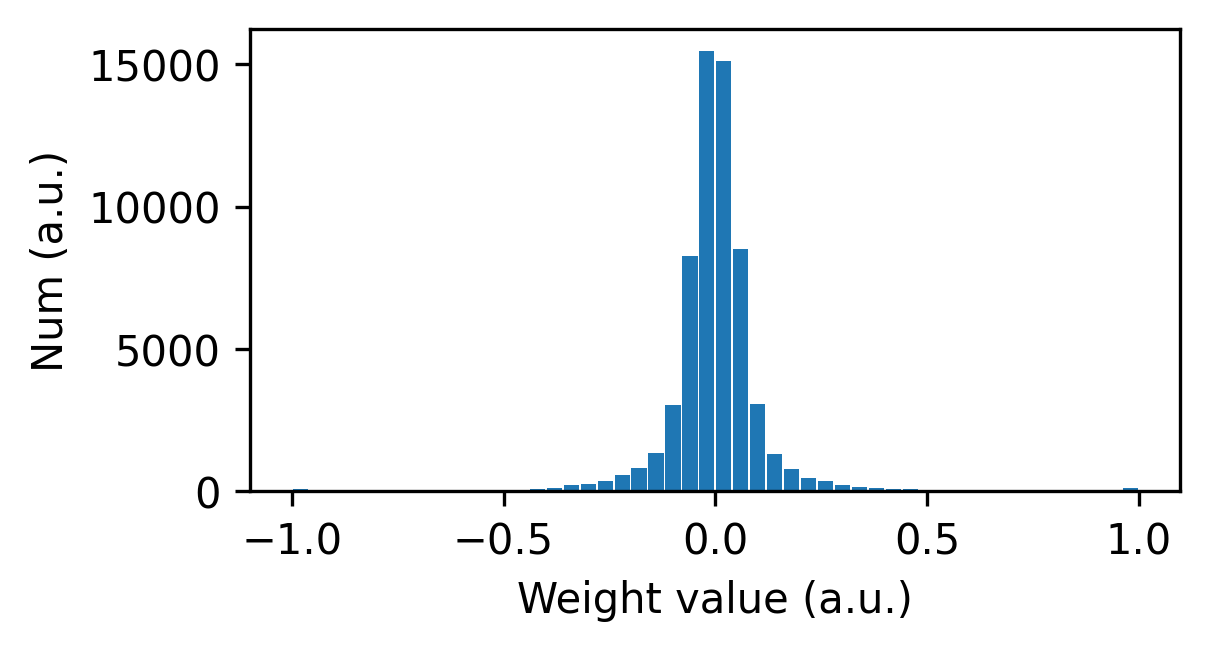

In [13]:
conv1_flat = net.conv1.cpu().weight.detach().numpy().flatten()
conv2_flat = net.conv2.cpu().weight.detach().numpy().flatten()
fc1_flat = net.fc1.cpu().weight.detach().numpy().flatten()
fc2_flat = net.fc2.cpu().weight.detach().numpy().flatten()
fc3_flat = net.fc3.cpu().weight.detach().numpy().flatten()
total_weight = np.hstack((conv1_flat, conv2_flat, fc1_flat, fc2_flat,fc3_flat))
print(np.min(total_weight))
print(np.max(total_weight))
plt.figure(figsize=(4,2),dpi=300)
plt.hist(total_weight,bins=50,range=(-1,1),rwidth=0.9)
plt.xlabel('Weight value (a.u.)')
plt.ylabel('Num (a.u.)')
plt.show()

In [14]:
file_name = '.\Training results/02-Standard NJ.pth'
if os.path.exists(file_name):
    print('file exist, save failed')
else:
    torch.save(net.state_dict(), file_name)
    print('save done')

save done


### Pruning
Reference: 

[1] Xu, T., Zhang, W., Zhang, J., Luo, Z., Xiao, Q., Wang, B., ... & Huang, C. (2024). Control-free and efficient integrated photonic neural networks via hardware-aware training and pruning. Optica, 11(8), 1039-1049.

In [17]:
net = LeNet5()

In [20]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 50, gamma = 0.5)

In [25]:
### To push as much weights to 1 while without reducing the accuracy, you need to use small learning rate, large epoch number and small regualrization coefficient
net.to(device)
for epoch in range(10):  
    running_loss = 0.0
    net.apply_constraints()
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss0 = criterion(outputs, labels)
        regu_num1 = torch.tensor(1*1e-2)
        regu_num1 = regu_num1.to(device)
        net.apply_constraints()
        ### Calculate the regularization term
        conv1_grad = lorentzian_curve_derivative(lorentzian_inv(net.conv1.weight, 1, 0, 0.15), 1, 0, 0.15)
        conv2_grad = lorentzian_curve_derivative(lorentzian_inv(net.conv2.weight, 1, 0, 0.15), 1, 0, 0.15)
        fc1_grad = lorentzian_curve_derivative(lorentzian_inv(net.fc1.weight, 1, 0, 0.15), 1, 0, 0.15)
        fc2_grad = lorentzian_curve_derivative(lorentzian_inv(net.fc2.weight, 1, 0, 0.15), 1, 0, 0.15)
        fc3_grad = lorentzian_curve_derivative(lorentzian_inv(net.fc3.weight, 1, 0, 0.15), 1, 0, 0.15)
        regu = torch.mul(torch.norm(fc1_grad, p=2),regu_num1) + torch.mul(torch.norm(fc2_grad, p=2),regu_num1) + torch.mul(torch.norm(fc3_grad, p=2),regu_num1) + torch.mul(torch.norm(conv1_grad, p=2),regu_num1) + torch.mul(torch.norm(conv2_grad, p=2),regu_num1)
        loss = loss0 + regu * 1
        loss.backward()
        optimizer.step()
        net.apply_constraints()
        running_loss += loss.item()
        if i % 600 == 599:   
            print(f'[{epoch + 1}, {i + 1:5d}] Classification loss:{loss0.cpu().detach().numpy():.3f} Regularization loss:{regu.cpu().detach().numpy()}')
            running_loss = 0.0

    scheduler.step()
    net.to(device)
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)         
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy 10000 test images: {100 * correct / total} %')
print('Finished Training')

-0.999
0.999


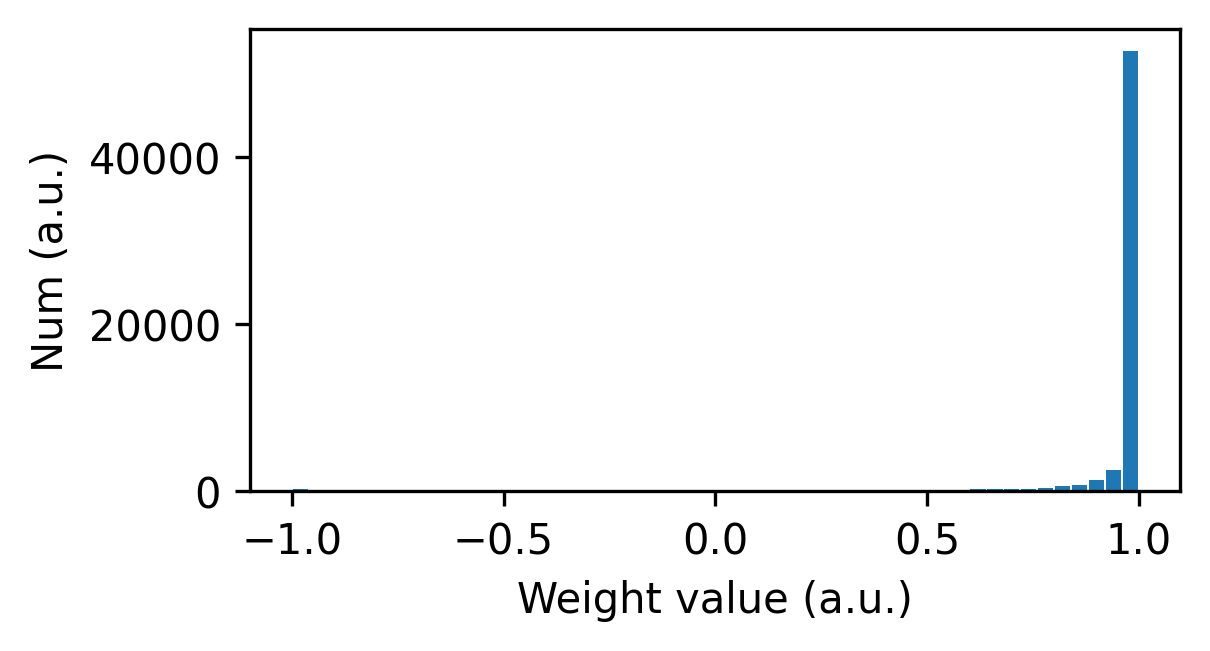

In [13]:
conv1_flat = net.conv1.cpu().weight.detach().numpy().flatten()
conv2_flat = net.conv2.cpu().weight.detach().numpy().flatten()
fc1_flat = net.fc1.cpu().weight.detach().numpy().flatten()
fc2_flat = net.fc2.cpu().weight.detach().numpy().flatten()
fc3_flat = net.fc3.cpu().weight.detach().numpy().flatten()
total_weight = np.hstack((conv1_flat, conv2_flat, fc1_flat, fc2_flat,fc3_flat))
print(np.min(total_weight))
print(np.max(total_weight))
plt.figure(figsize=(4,2),dpi=300)
plt.hist(total_weight,bins=50,range=(-1,1),rwidth=0.9)
plt.xlabel('Weight value (a.u.)')
plt.ylabel('Num (a.u.)')
plt.show()

In [ ]:
file_name = '.\Training results/03-Pruning.pth'
if os.path.exists(file_name):
    print('file exist, save failed')
else:
    torch.save(net.state_dict(), file_name)
    print('save done')

### SAT in-silico (This work)

In [19]:
from sam import SAM

In [20]:
net = LeNet5()
net.to(device)
net_Lorentz = LeNet5_Lorentz()
net_Lorentz.to(device)

LeNet5_Lorentz(
  (conv1): Conv2dLorentz(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2dLorentz(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): LinearLorentz(in_features=400, out_features=120, bias=True)
  (fc2): LinearLorentz(in_features=120, out_features=84, bias=True)
  (fc3): LinearLorentz(in_features=84, out_features=10, bias=True)
  (norm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm3): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm4): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [21]:
net_Lorentz.conv1.weight.data = lorentzian_inv(net.conv1.weight.data, A=1, x0=0, gamma=0.15)
net_Lorentz.conv2.weight.data = lorentzian_inv(net.conv2.weight.data, A=1, x0=0, gamma=0.15)
net_Lorentz.fc1.weight.data = lorentzian_inv(net.fc1.weight.data, A=1, x0=0, gamma=0.15)
net_Lorentz.fc2.weight.data = lorentzian_inv(net.fc2.weight.data, A=1, x0=0, gamma=0.15)
net_Lorentz.fc3.weight.data = lorentzian_inv(net.fc3.weight.data, A=1, x0=0, gamma=0.15)

In [22]:
conv1_flat = net_Lorentz.conv1.cpu().weight.detach().numpy().flatten()
conv2_flat = net_Lorentz.conv2.cpu().weight.detach().numpy().flatten()
fc1_flat = net_Lorentz.fc1.cpu().weight.detach().numpy().flatten()
fc2_flat = net_Lorentz.fc2.cpu().weight.detach().numpy().flatten()
fc3_flat = net_Lorentz.fc3.cpu().weight.detach().numpy().flatten()
total_weight = np.hstack((conv1_flat, conv2_flat, fc1_flat, fc2_flat, fc3_flat))

In [23]:
net_Lorentz.to(device)
base_optimizer = torch.optim.Adam
optimizer = SAM(net_Lorentz.parameters(), rho=0.5, base_optimizer=base_optimizer,lr=0.01,adaptive=True)
for epoch in range(20):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        ### First forward propagation
        outputs = net_Lorentz(inputs)
        loss0 = criterion(outputs, labels)
        loss = loss0
        optimizer.zero_grad()
        loss.backward()
        optimizer.first_step(zero_grad=True)
        ### Second forward propagation
        outputsSAM = net_Lorentz(inputs)
        lossSAM0 = criterion(outputsSAM, labels)
        lossSAM = lossSAM0
        lossSAM.backward()
        optimizer.second_step(zero_grad=True) 
        running_loss += loss.item()
        if i % 600 == 599:    
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 600:.3f}')
            running_loss = 0.0
    scheduler.step()

    net_Lorentz.to(device)
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net_Lorentz(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy 10000 test images: {100 * correct / total} %')
print('Finished Training')

[1,   600] loss: 0.173
Accuracy 10000 test images: 98.48 %
[2,   600] loss: 0.053
Accuracy 10000 test images: 98.76 %
[3,   600] loss: 0.038
Accuracy 10000 test images: 98.99 %
[4,   600] loss: 0.032
Accuracy 10000 test images: 99.03 %
[5,   600] loss: 0.026
Accuracy 10000 test images: 99.07 %
[6,   600] loss: 0.024
Accuracy 10000 test images: 99.1 %
[7,   600] loss: 0.021
Accuracy 10000 test images: 99.13 %
[8,   600] loss: 0.016
Accuracy 10000 test images: 99.22 %
[9,   600] loss: 0.016
Accuracy 10000 test images: 99.12 %
[10,   600] loss: 0.014
Accuracy 10000 test images: 99.16 %
[11,   600] loss: 0.012
Accuracy 10000 test images: 99.12 %
[12,   600] loss: 0.011
Accuracy 10000 test images: 99.22 %
[13,   600] loss: 0.010
Accuracy 10000 test images: 99.1 %
[14,   600] loss: 0.009
Accuracy 10000 test images: 99.19 %
[15,   600] loss: 0.009
Accuracy 10000 test images: 99.2 %
[16,   600] loss: 0.008
Accuracy 10000 test images: 99.24 %
[17,   600] loss: 0.007
Accuracy 10000 test images: 

In [24]:
conv1_flat = net_Lorentz.conv1.cpu().weight.detach().numpy().flatten()
conv2_flat = net_Lorentz.conv2.cpu().weight.detach().numpy().flatten()
fc1_flat = net_Lorentz.fc1.cpu().weight.detach().numpy().flatten()
fc2_flat = net_Lorentz.fc2.cpu().weight.detach().numpy().flatten()
fc3_flat = net_Lorentz.fc3.cpu().weight.detach().numpy().flatten()
total_weight = np.hstack((conv1_flat, conv2_flat, fc1_flat, fc2_flat, fc3_flat))
print(np.min(lorentzian_curve(total_weight, A=1, x0=0, gamma=0.15)))
print(np.max(lorentzian_curve(total_weight, A=1, x0=0, gamma=0.15)))

-1.0
0.93331486


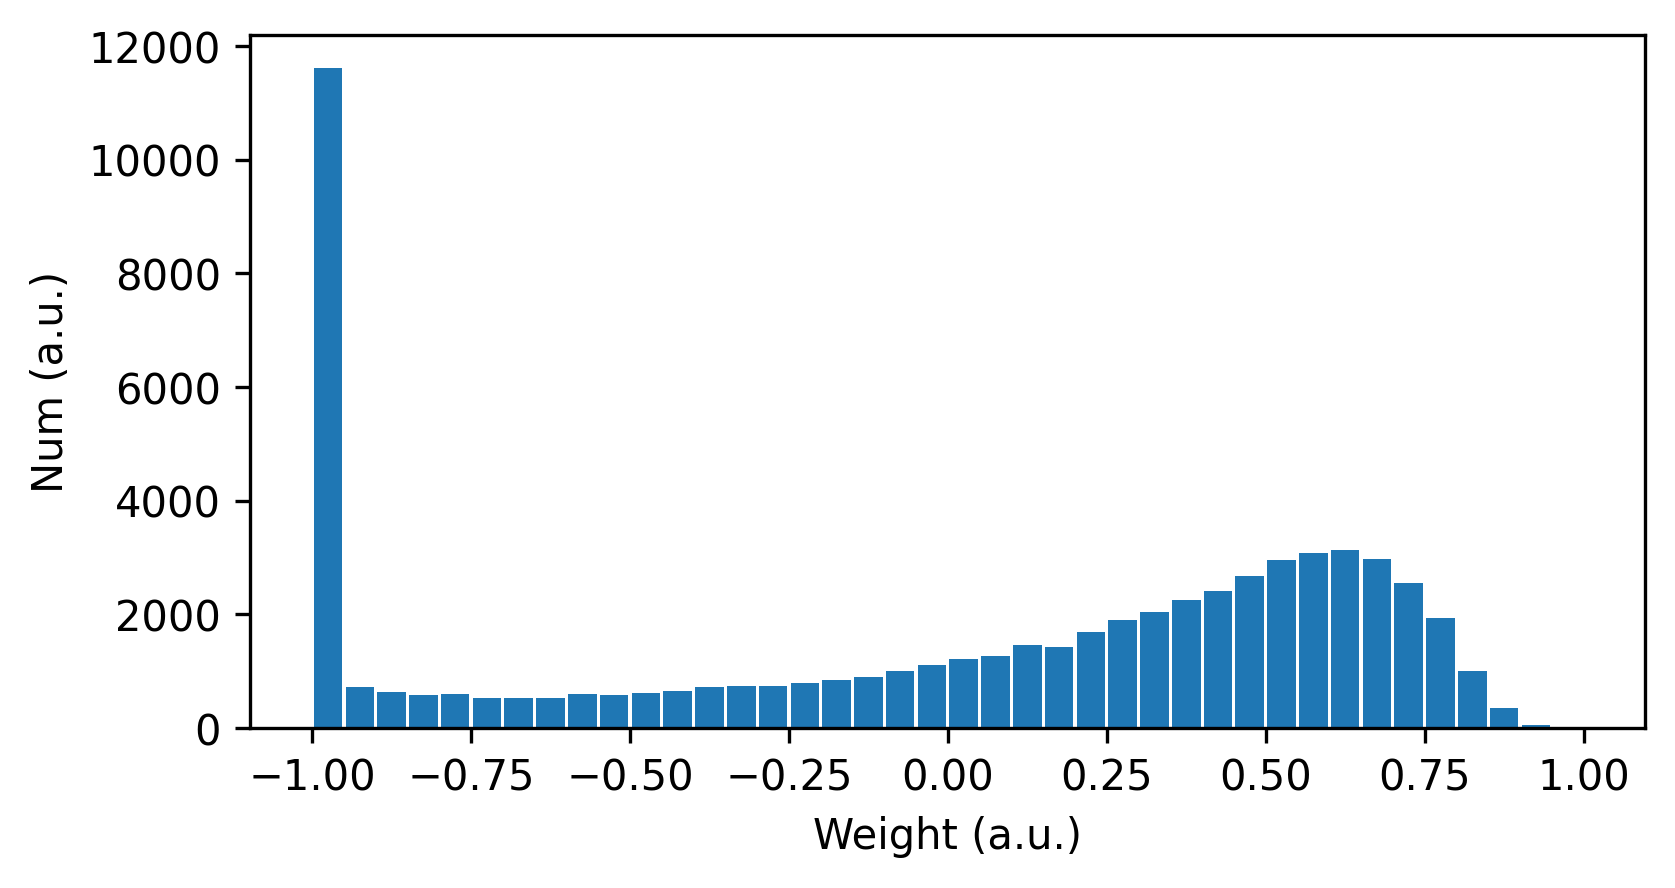

In [25]:
plt.figure(dpi=300,figsize=(6,3))
plt.hist(lorentzian_curve(total_weight, A=1, x0=0, gamma=0.15),bins=40,range=(-1,1),rwidth=0.9)
plt.xlabel('Weight (a.u.)')
plt.ylabel('Num (a.u.)')
plt.show()

In [26]:
file_name = '.\Training results/04-SAT_Lorentz.pth'
if os.path.exists(file_name):
    print('file exist, save failed')
else:
    torch.save(net_Lorentz.state_dict(), file_name)
    print('save done')

save done


In [27]:
PATH = '.\Training results/04-SAT_Lorentz.pth'
net = LeNet5()
net.load_state_dict(torch.load(PATH))
net_Lorentz = LeNet5_Lorentz()
net_Lorentz.load_state_dict(torch.load(PATH))
PATH = ""

In [28]:
net.conv1.weight.data = lorentzian_curve(net_Lorentz.conv1.weight.data, A=1, x0=0, gamma=0.15)
net.conv2.weight.data = lorentzian_curve(net_Lorentz.conv2.weight.data, A=1, x0=0, gamma=0.15)
net.fc1.weight.data = lorentzian_curve(net_Lorentz.fc1.weight.data, A=1, x0=0, gamma=0.15)
net.fc2.weight.data = lorentzian_curve(net_Lorentz.fc2.weight.data, A=1, x0=0, gamma=0.15)
net.fc3.weight.data = lorentzian_curve(net_Lorentz.fc3.weight.data, A=1, x0=0, gamma=0.15)

In [29]:
file_name = '.\Training results/04-SAT.pth'
if os.path.exists(file_name):
    print('file exist, save failed')
else:
    torch.save(net.state_dict(), file_name)
    print('save done')

save done


### PAT in-situ 

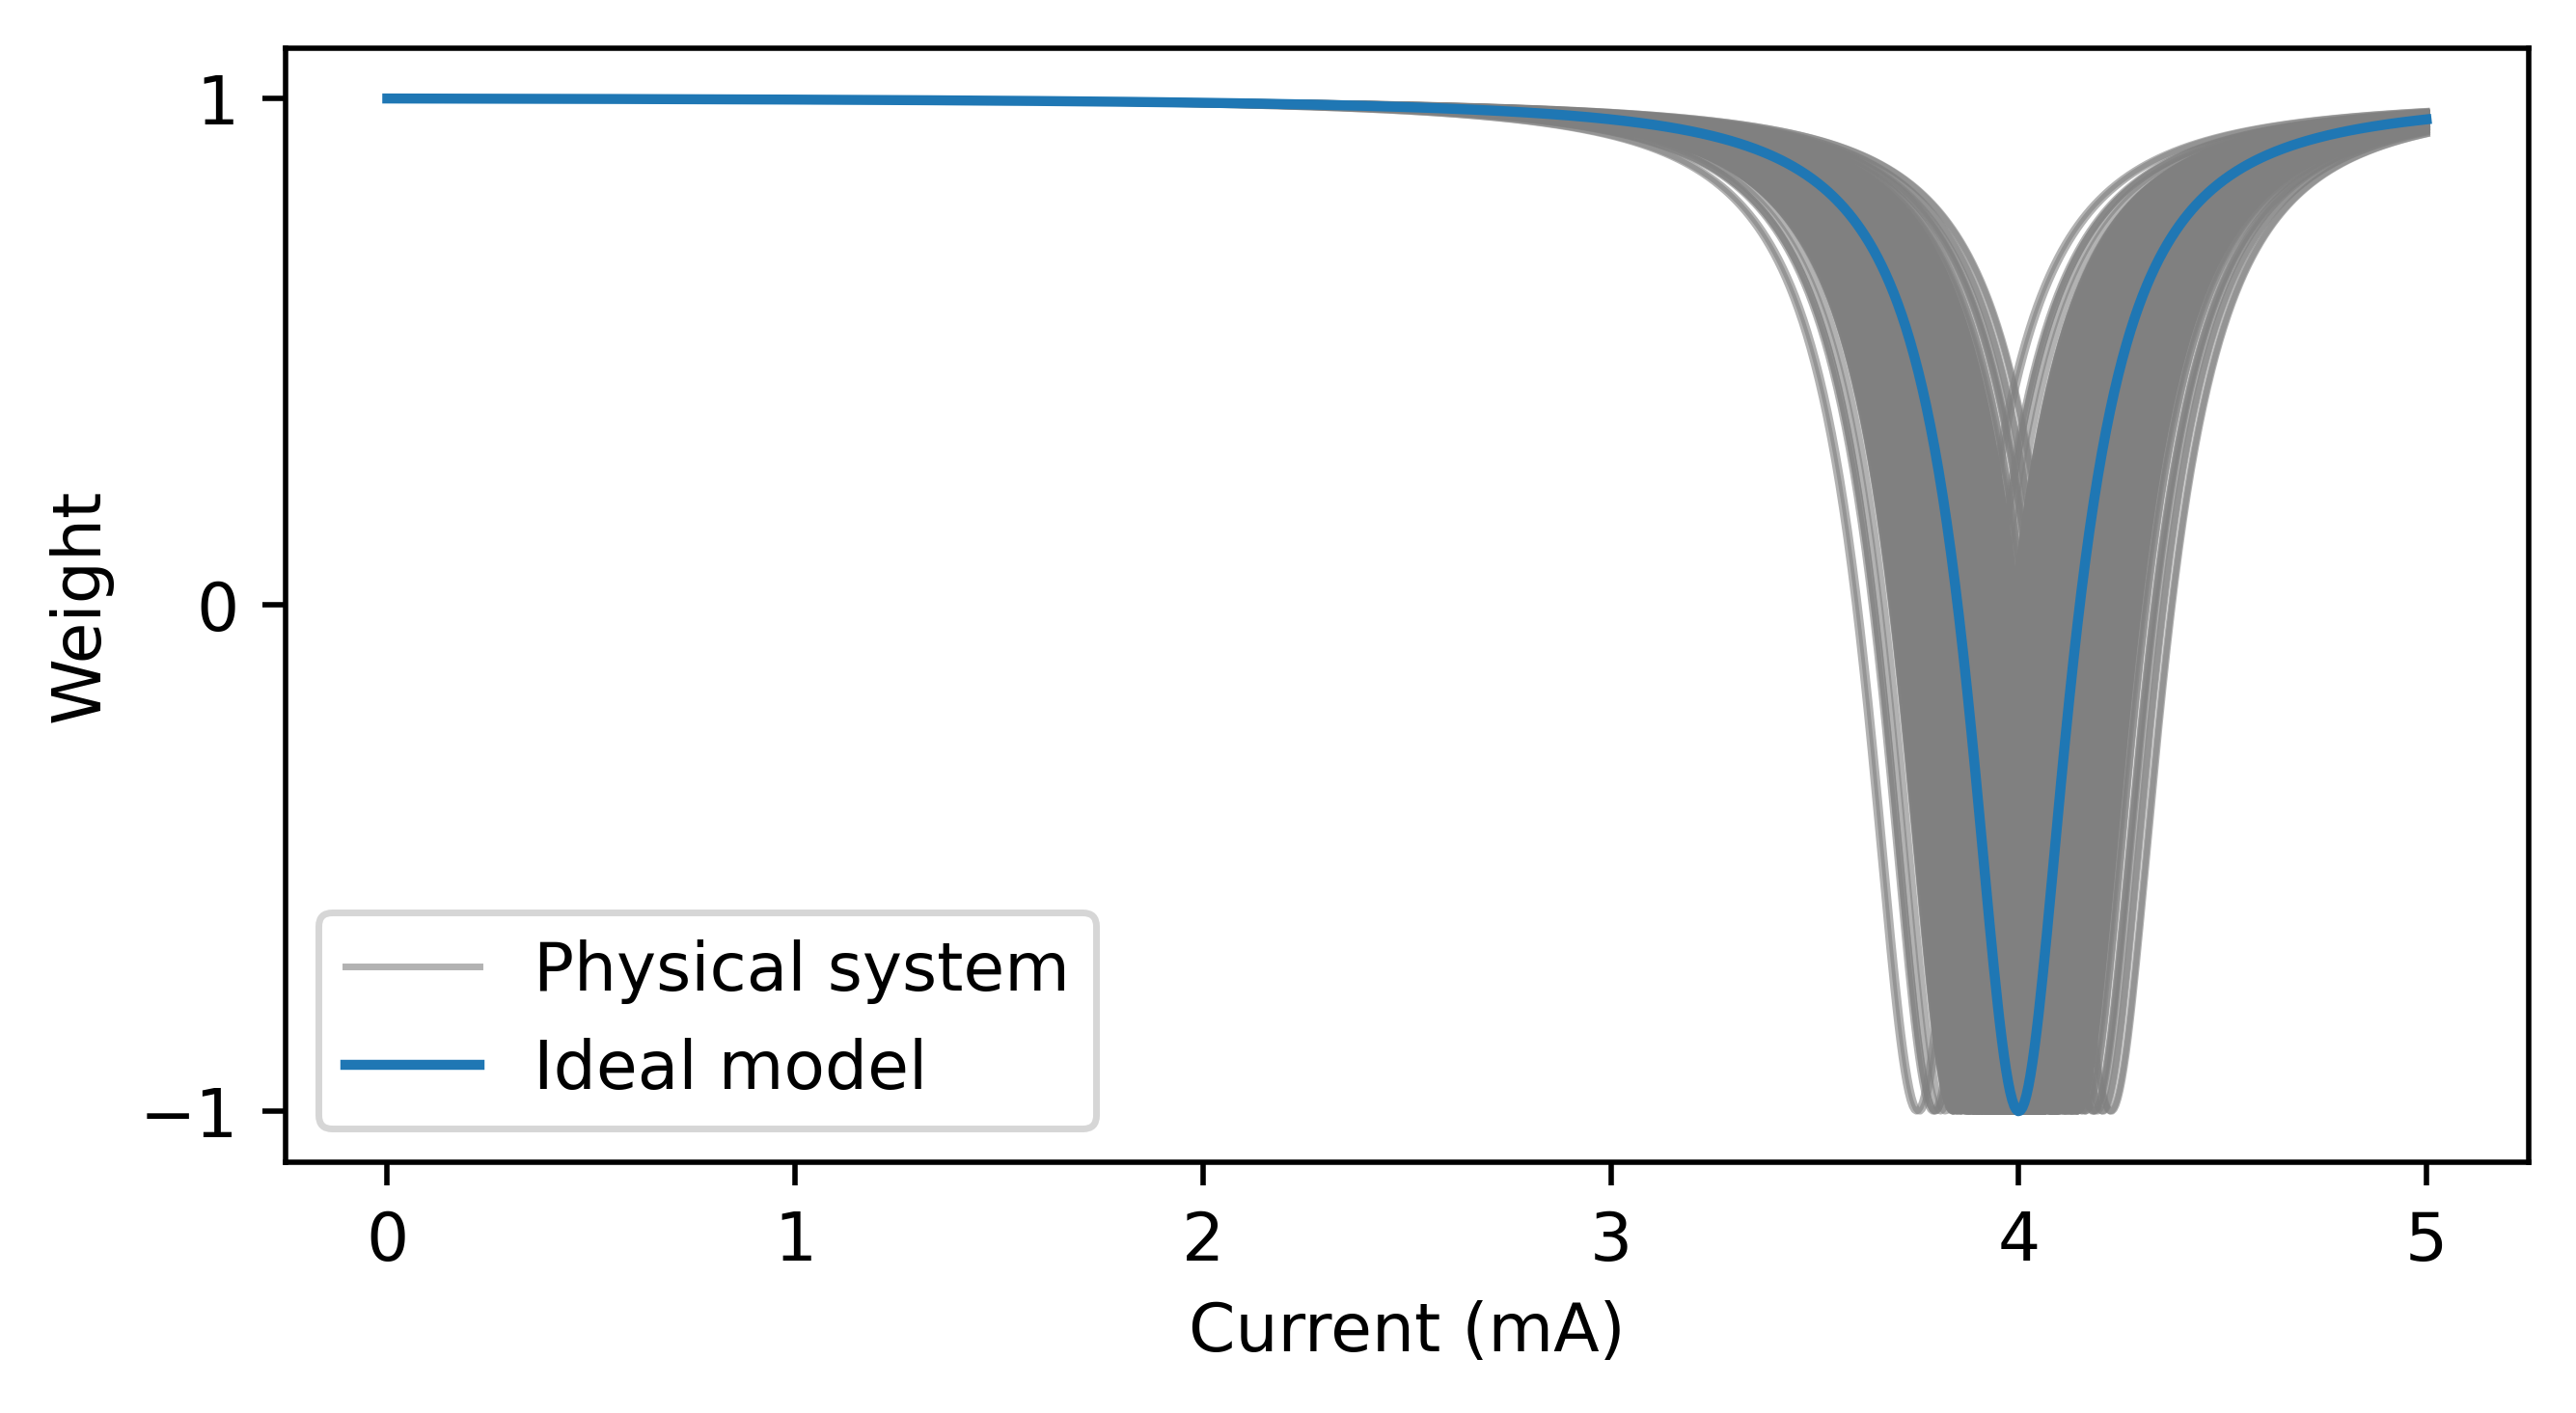

In [10]:
### Forward model
import matplotlib.pylab as plt
plt.rcParams.update(plt.rcParamsDefault)
plt.figure(dpi=500,figsize=(6,3))
var_level = 0.08
x_range = np.linspace(-4, 1, 1000)
y = lorentzian_curve(x_range, 1, np.random.randn()*var_level, 0.15)
y = (y-np.min(y))/(np.max(y)-np.min(y)) * 2 -1
plt.plot((x_range + 4) ** 1, y, label='Physical system',linewidth=1.0,alpha=0.6,color='gray')
for ite in range(500):
    y = lorentzian_curve(x_range, 1, np.random.randn()*var_level, 0.15)
    y = (y-np.min(y))/(np.max(y)-np.min(y)) * 2 -1
    plt.plot((x_range + 4) ** 1, y,linewidth=1.0,alpha=0.6,color='gray')

### Backward model
x_range = np.linspace(-4, 1, 1000)
y = lorentzian_curve(x_range, 1, 0, 0.15)
y = (y-np.min(y))/(np.max(y)-np.min(y)) * 2 -1
plt.plot((x_range + 4) ** 1, y, label='Ideal model',linewidth=1.5,alpha=1,color='C0')

plt.xticks([0, 1, 2, 3, 4, 5])
plt.yticks([-1, 0, 1])
plt.ylim([-1.1,1.1])
plt.legend()
plt.xlabel('Current (mA)')
plt.ylabel('Weight')
plt.show()

In [11]:
net = LeNet5()
net.to(device)

LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (norm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm3): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm4): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [12]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 400, gamma = 0.5)

In [13]:
fc2 = net.fc2.cpu().weight.detach().numpy()
fc3 = net.fc3.cpu().weight.detach().numpy()
fc2_variance = np.random.randn(fc2.shape[0],fc2.shape[1])*0.08
fc3_variance = np.random.randn(fc3.shape[0],fc3.shape[1])*0.08

In [14]:
net.to(device)
for epoch in range(20):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        ### Ideal forward
        outputs = net(inputs)
        ### Physical forward (Our experiments perform fc2 & fc3 inference, therefore we add resonance only to fc2 & fc3)
        fc2 = net.fc2.cpu().weight.detach().numpy()
        fc3 = net.fc3.cpu().weight.detach().numpy()
        fc2_noise = lorentzian_curve(lorentzian_inv(fc2, A=1, x0=0, gamma=0.15)+fc2_variance, A=1, x0=0, gamma=0.15)
        fc3_noise = lorentzian_curve(lorentzian_inv(fc3, A=1, x0=0, gamma=0.15)+fc3_variance, A=1, x0=0, gamma=0.15)  
        net.fc2.weight.data = torch.tensor(fc2_noise).float().to(device)
        net.fc3.weight.data = torch.tensor(fc3_noise).float().to(device)
        net.to(device) 
        with torch.no_grad():
            outputs_phy = net(inputs)
        net.fc2.weight.data = torch.tensor(fc2).float().to(device)
        net.fc3.weight.data = torch.tensor(fc3).float().to(device)
        net.to(device)
        ### Replace phy with ideal
        with torch.no_grad():
            outputs.data.copy_(outputs_phy.data)    
        ### Update ideal model
        loss0 = criterion(outputs, labels)
        loss = loss0
        loss.backward()
        optimizer.step()
        net.apply_constraints()
        running_loss += loss.item()
        if i % 600 == 599:    
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 600:.3f} Classification loss:{loss0.cpu().detach().numpy():.3f}')
            running_loss = 0.0
    scheduler.step()
    net.to(device)
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            ### Physical forward
            fc2 = net.fc2.cpu().weight.detach().numpy()
            fc3 = net.fc3.cpu().weight.detach().numpy()
            fc2_noise = lorentzian_curve(lorentzian_inv(fc2, A=1, x0=0, gamma=0.15)+fc2_variance, A=1, x0=0, gamma=0.15)
            fc3_noise = lorentzian_curve(lorentzian_inv(fc3, A=1, x0=0, gamma=0.15)+fc3_variance, A=1, x0=0, gamma=0.15)      
            net.fc2.weight.data = torch.tensor(fc2_noise).float().to(device)
            net.fc3.weight.data = torch.tensor(fc3_noise).float().to(device)
            net.to(device) 
            outputs = net(inputs)
            net.fc2.weight.data = torch.tensor(fc2).float().to(device)
            net.fc3.weight.data = torch.tensor(fc3).float().to(device)
            net.to(device)              
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy 10000 test images: {100 * correct / total} %')
print('Finished Training')

[1,   600] loss: 10.377 Classification loss:12.494
Accuracy 10000 test images: 67.26 %
[2,   600] loss: 3.311 Classification loss:3.329
Accuracy 10000 test images: 92.61 %
[3,   600] loss: 0.986 Classification loss:0.972
Accuracy 10000 test images: 95.31 %
[4,   600] loss: 0.748 Classification loss:0.541
Accuracy 10000 test images: 96.33 %
[5,   600] loss: 0.646 Classification loss:1.454
Accuracy 10000 test images: 96.58 %
[6,   600] loss: 0.461 Classification loss:0.037
Accuracy 10000 test images: 97.49 %
[7,   600] loss: 0.393 Classification loss:0.140
Accuracy 10000 test images: 97.37 %
[8,   600] loss: 0.333 Classification loss:0.004
Accuracy 10000 test images: 97.88 %
[9,   600] loss: 0.298 Classification loss:0.822
Accuracy 10000 test images: 97.87 %
[10,   600] loss: 0.277 Classification loss:0.011
Accuracy 10000 test images: 97.76 %
[11,   600] loss: 0.230 Classification loss:0.000
Accuracy 10000 test images: 97.81 %
[12,   600] loss: 0.213 Classification loss:0.105
Accuracy 10

In [16]:
epochs = list(range(1, 21))
losses = [10.377, 3.311, 0.986, 0.748, 0.646, 0.461, 0.393, 0.333, 0.298, 0.277, 0.23, 0.213, 0.191, 0.178, 0.203, 0.172, 0.149, 0.146, 0.132, 0.144]
accu = [67.26, 92.61, 95.31, 96.33, 96.58, 97.49, 97.37, 97.88, 97.87, 97.76, 97.81, 97.65, 97.98, 98.11, 97.87, 97.79, 98.24, 98.2, 98.05, 98.03]

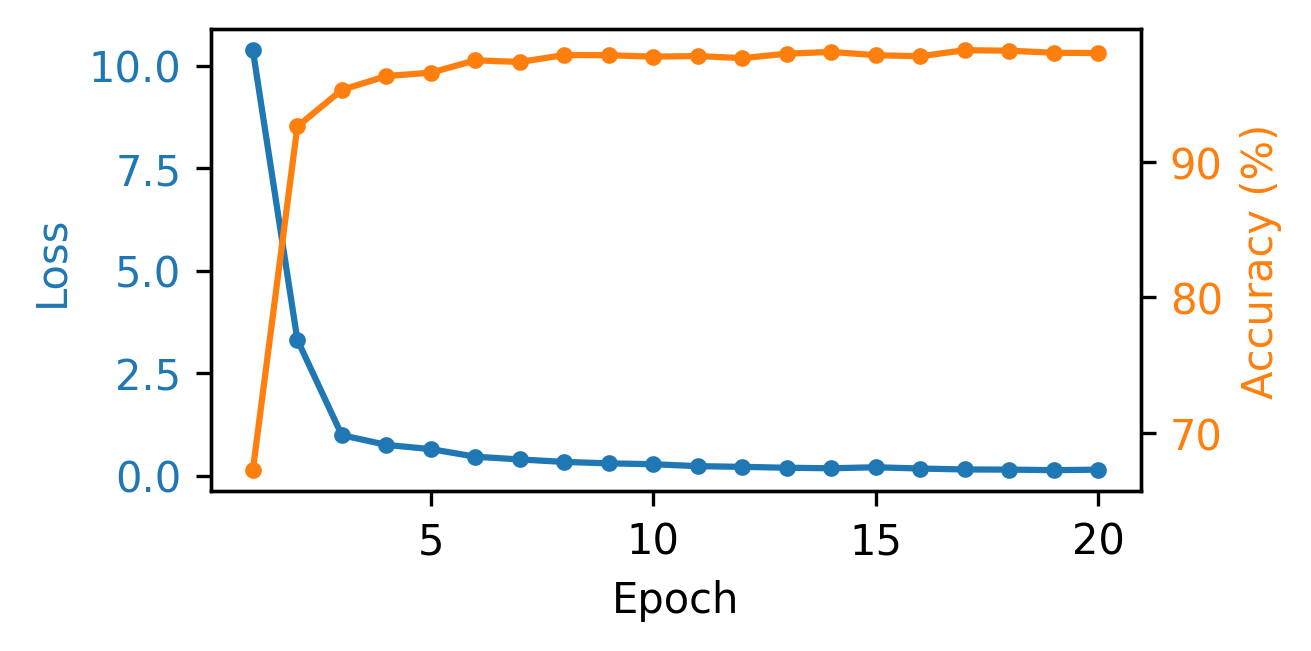

In [31]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax1 = plt.subplots(figsize=(4,2),dpi=300)

# 绘制 loss 随时间变化的曲线
ax1.plot(epochs, losses, '.-', label='Loss',color='C0')
ax1.tick_params(axis='y', labelcolor='C0')
ax1.set_ylabel('Loss',color='C0')
# 创建右坐标轴
ax2 = ax1.twinx()
ax2.plot(epochs, accu, '.-', label='Accuracy',color='C1')
ax2.tick_params(axis='y', labelcolor='C1')
ax2.set_ylabel('Accuracy (%)',color='C1')
ax1.set_xlabel('Epoch')
plt.show()


-0.999
0.999


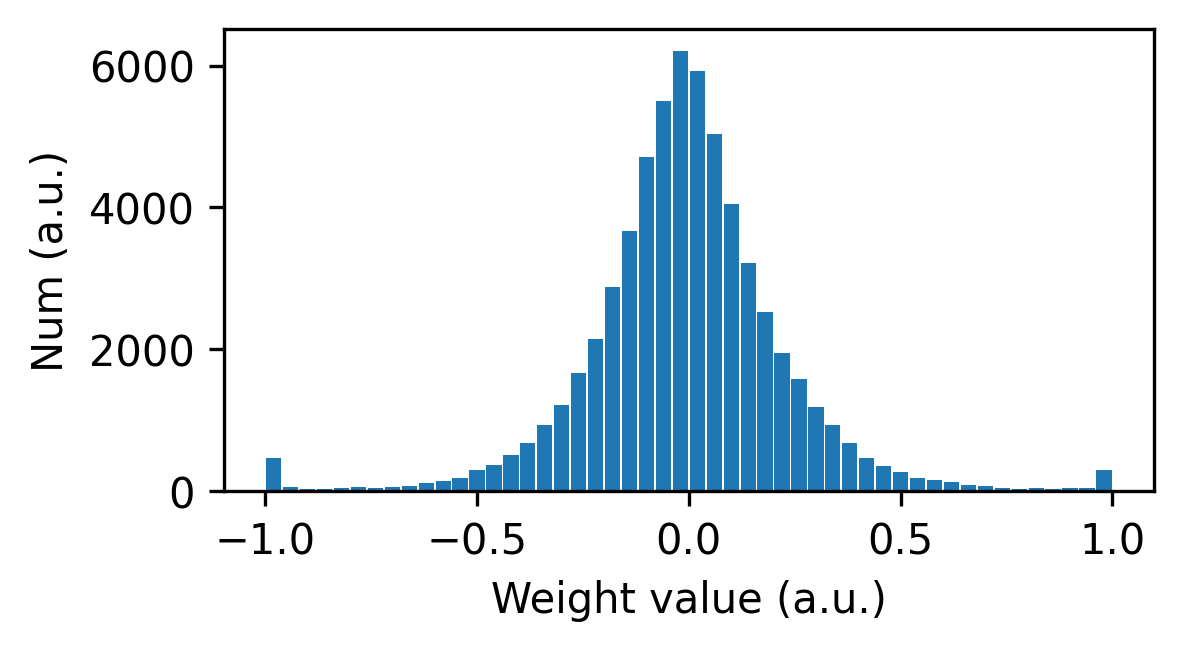

In [42]:
conv1_flat = net.conv1.cpu().weight.detach().numpy().flatten()
conv2_flat = net.conv2.cpu().weight.detach().numpy().flatten()
fc1_flat = net.fc1.cpu().weight.detach().numpy().flatten()
fc2_flat = net.fc2.cpu().weight.detach().numpy().flatten()
fc3_flat = net.fc3.cpu().weight.detach().numpy().flatten()
total_weight = np.hstack((conv1_flat, conv2_flat, fc1_flat, fc2_flat,fc3_flat))
print(np.min(total_weight))
print(np.max(total_weight))
plt.figure(figsize=(4,2),dpi=300)
plt.hist(total_weight,bins=50,range=(-1,1),rwidth=0.9)
plt.xlabel('Weight value (a.u.)')
plt.ylabel('Num (a.u.)')
plt.show()

In [43]:
file_name = '.\Training results/05-PAT.pth'
if os.path.exists(file_name):
    print('file exist, save failed')
else:
    torch.save(net.state_dict(), file_name)
    print('save done')

save done
